<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imporitng-Required-Packages" data-toc-modified-id="Imporitng-Required-Packages-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imporitng Required Packages</a></span></li><li><span><a href="#Importing-Dataset" data-toc-modified-id="Importing-Dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Importing Dataset</a></span></li><li><span><a href="#Train-Test-Split" data-toc-modified-id="Train-Test-Split-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Train Test Split</a></span></li><li><span><a href="#ARMA-Model" data-toc-modified-id="ARMA-Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>ARMA Model</a></span><ul class="toc-item"><li><span><a href="#Estimating-Lags" data-toc-modified-id="Estimating-Lags-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Estimating Lags</a></span></li></ul></li><li><span><a href="#Modeling-ARMA(1,-1)-Residuals" data-toc-modified-id="Modeling-ARMA(1,-1)-Residuals-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Modeling ARMA(1, 1) Residuals</a></span><ul class="toc-item"><li><span><a href="#GARCH-Model" data-toc-modified-id="GARCH-Model-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>GARCH Model</a></span><ul class="toc-item"><li><span><a href="#Estimating-Lags" data-toc-modified-id="Estimating-Lags-5.1.1"><span class="toc-item-num">5.1.1&nbsp;&nbsp;</span>Estimating Lags</a></span></li><li><span><a href="#GARCH(2,-2)-Model" data-toc-modified-id="GARCH(2,-2)-Model-5.1.2"><span class="toc-item-num">5.1.2&nbsp;&nbsp;</span>GARCH(2, 2) Model</a></span></li></ul></li></ul></li><li><span><a href="#ARMA(1,-1)-(Predictions)---GARCH(2,-2)-(Confidence-Levels)-Model" data-toc-modified-id="ARMA(1,-1)-(Predictions)---GARCH(2,-2)-(Confidence-Levels)-Model-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>ARMA(1, 1) (Predictions) - GARCH(2, 2) (Confidence Levels) Model</a></span></li></ul></div>

# Imporitng Required Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX

from arch import arch_model

from sklearn.metrics import mean_squared_error

import warnings

sns.set()
warnings.filterwarnings("ignore")

# Importing Dataset

In [2]:
file_path = "../data.csv"

In [3]:
data_backup = pd.read_csv(file_path)
data_backup.Date = pd.to_datetime(data_backup.Date)
data_backup.set_index("Date", inplace = True)

In [4]:
data = data_backup[["spx_ret", "spx_vol"]]

# Train Test Split

In [5]:
train_df = data.loc[:"2018-12-31"]
test_df = data.loc["2019-01-01":]

# ARMA Model

## Estimating Lags

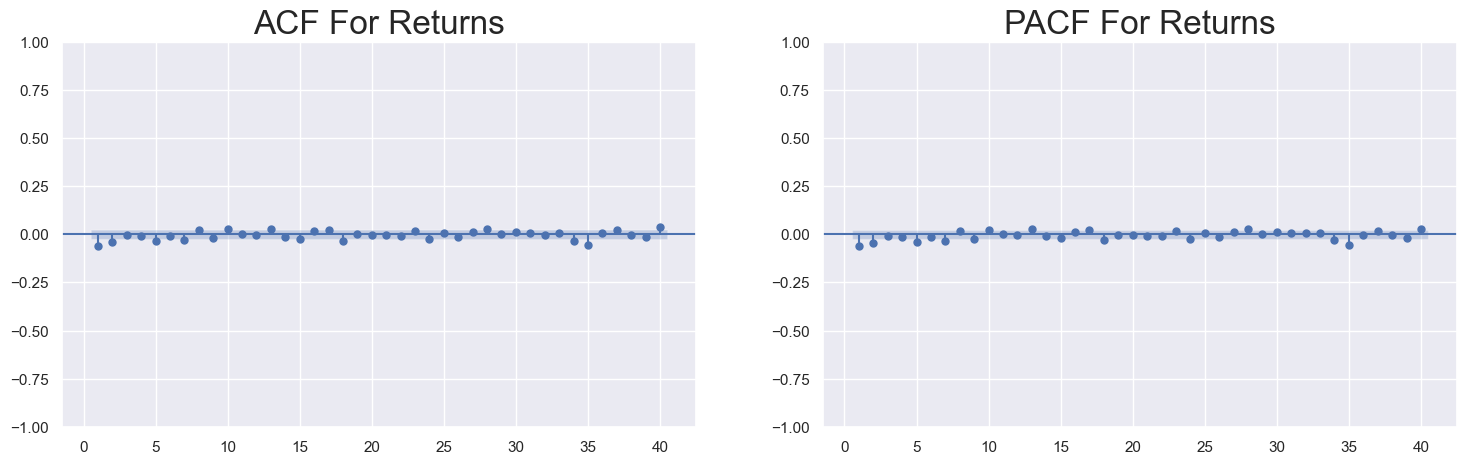

In [6]:
plt.rcParams["figure.figsize"] = 18, 5

fig, axes = plt.subplots(1, 2)

sgt.plot_acf(train_df.spx_ret[1:], zero = False, lags = 40, ax = axes[0])
sgt.plot_pacf(train_df.spx_ret[1:], zero = False, lags = 40, ax = axes[1])

axes[0].set_title("ACF For Returns", size = 24)
axes[1].set_title("PACF For Returns", size = 24)

plt.show()

**Building the Model**

In [7]:
model = SARIMAX(train_df["spx_ret"][1:], order = (1, 0, 1))
model_results = model.fit()
print(model_results.summary())

                               SARIMAX Results                                
Dep. Variable:                spx_ret   No. Observations:                 6517
Model:               SARIMAX(1, 0, 1)   Log Likelihood              -10024.948
Date:                Tue, 05 Dec 2023   AIC                          20055.897
Time:                        08:09:28   BIC                          20076.243
Sample:                    01-07-1994   HQIC                         20062.933
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6462      0.047     13.689      0.000       0.554       0.739
ma.L1         -0.7075      0.043    -16.560      0.000      -0.791      -0.624
sigma2         1.2696      0.010    128.105      0.0

**Predictions**

In [8]:
arma_forecast = model_results.get_forecast(len(test_df.index))
arma_predictions_df = arma_forecast.conf_int(alpha = 0.05) # Confidence level of 95%
arma_predictions_df["Predictions"] = model_results.predict(start = test_df.index[0], end = test_df.index[-1])

**Plot of Predicted vs Actual Values**

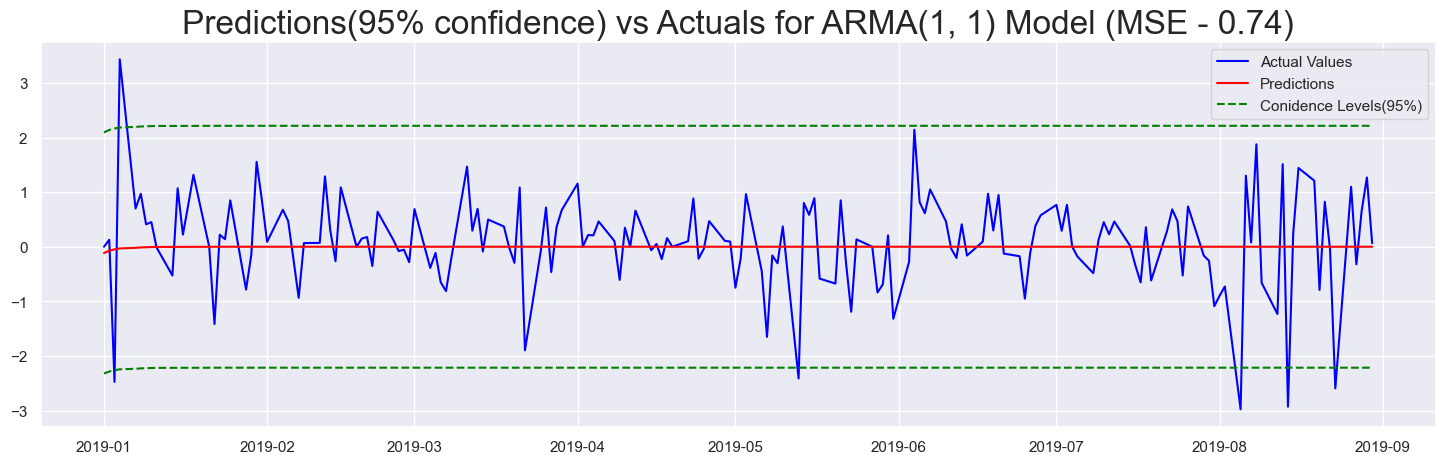

In [9]:
arma_mse = mean_squared_error(test_df["spx_ret"].values, arma_predictions_df["Predictions"])

plt.rcParams["figure.figsize"] = 18, 5

plt.plot(test_df["spx_ret"], color = "blue", label = "Actual Values")

plt.plot(arma_predictions_df["Predictions"], color = "red", label = "Predictions")
plt.plot(arma_predictions_df["upper spx_ret"], color = "green", linestyle = "--", label = "Conidence Levels(95%)")
plt.plot(arma_predictions_df["lower spx_ret"], color = "green", linestyle = "--")

plt.title(f"Predictions(95% confidence) vs Actuals for ARMA(1, 1) Model (MSE - {round(arma_mse, 2)})", size = 24)

plt.legend()
plt.show()

# Modeling ARMA(1, 1) Residuals

Plotting **Residuals** of **ARMA(1, 1)** Model

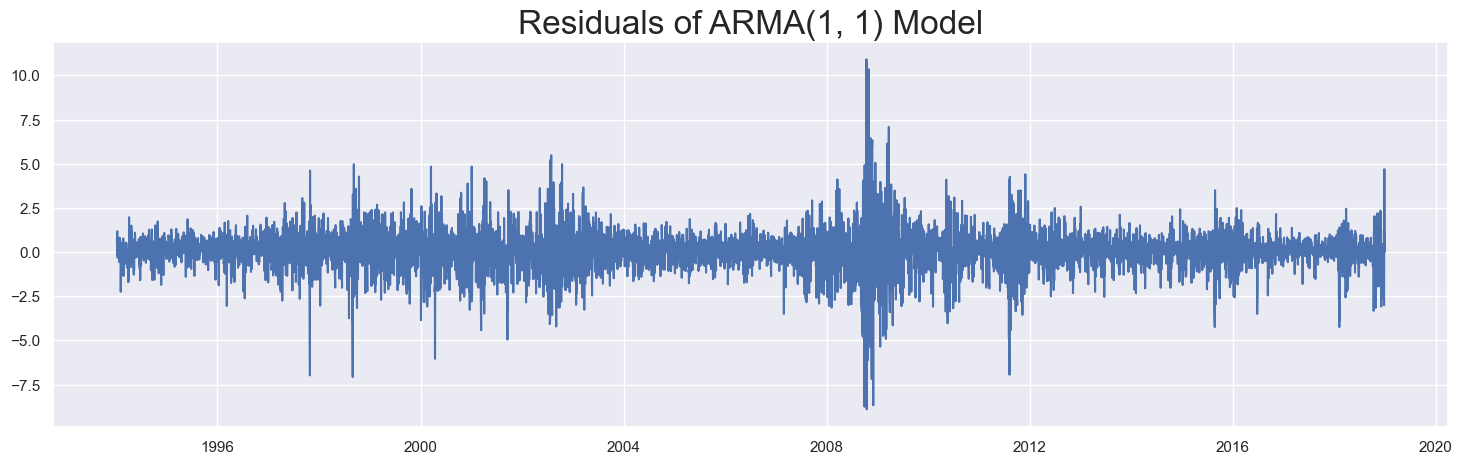

In [10]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(model_results.resid)
plt.title("Residuals of ARMA(1, 1) Model", size = 24)

plt.show()

Through this plot, it is obvious that the variance varies with time and hence modeling this with a **GARCH** model may be reasonable. 

## GARCH Model

### Estimating Lags

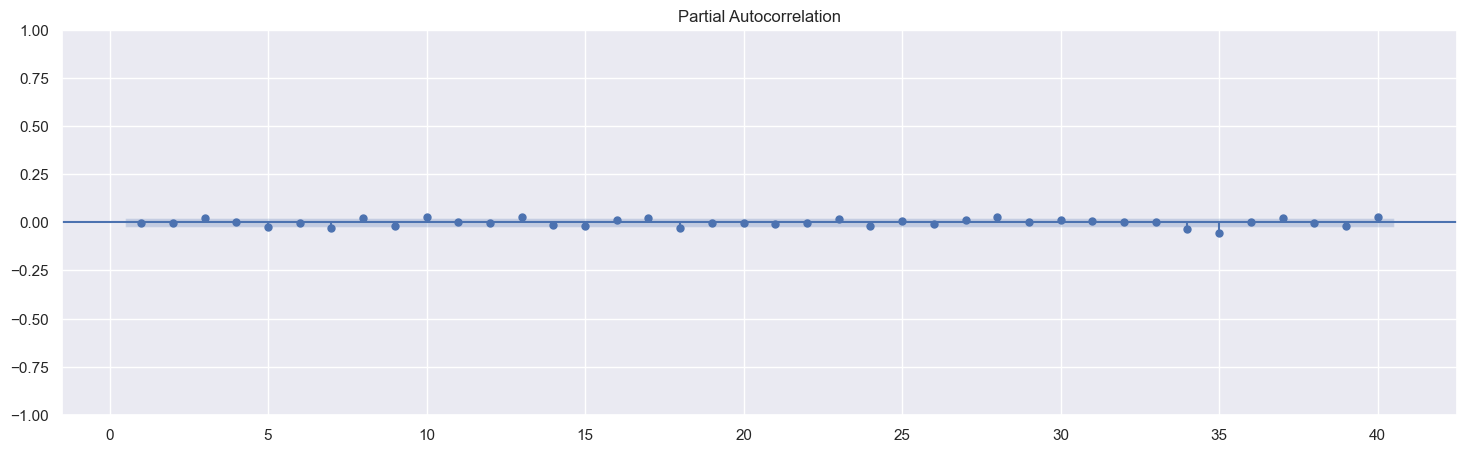

In [11]:
plt.rcParams["figure.figsize"] = 18, 5

sgt.plot_pacf(model_results.resid[1:], zero = False, lags = 40)

plt.show()

### GARCH(2, 2) Model

**Preparing Data**

In [13]:
resid_df = data.copy()
resid_df["spx_ret_resid"] = resid_df["spx_ret"].shift(1).loc[resid_df.index]
resid_df.loc[train_df.index[1]:train_df.index[-1], "spx_ret_resid"] = model_results.resid

**Building the Model**

**Note**: In some cases, the model may fail to converge. In such case, running the code cell below will most likely fix the issue. However, one can also follow the approach given [here](https://quant.stackexchange.com/questions/32350/fitting-garch1-1-in-python-for-moderately-large-data-sets) for a more robust solution.

In [14]:
resid_model = arch_model(resid_df["spx_ret_resid"][1:], p = 2, q = 2, vol = "GARCH")
resid_model_results = resid_model.fit(last_obs = test_df.index[0], update_freq = 5)
resid_model_results.summary()

Iteration:      5,   Func. Count:     49,   Neg. LLF: 3069579429.341548
Iteration:     10,   Func. Count:     91,   Neg. LLF: 8621.106372239967
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8620.971400166818
            Iterations: 14
            Function evaluations: 119
            Gradient evaluations: 14


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:          spx_ret_resid   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8620.97
Distribution:                  Normal   AIC:                           17253.9
Method:            Maximum Likelihood   BIC:                           17294.6
                                        No. Observations:                 6517
Date:                Tue, Dec 05 2023   Df Residuals:                     6516
Time:                        08:10:05   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0761  9.927e-03      7.665  1.794e-14 [5.663e-02,9.555e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0255  6.713e-03      3.806  1.415e-04 [1.239e-02,3.870e-02]
alpha[1]       0.0587  1.611e-02      3.643  2.695e-04 [2.711e-02,9.024e-02]
alpha[2]       0.0987  2.147e-02      4.596  4.299e-06   [5.661e-02,  0.141]
beta[1]        0.3051      0.139      2.190  2.852e-02   [3.206e-02,  0.578]
beta[2]        0.5174      0.129      4.026  5.671e-05     [  0.266,  0.769]
============================================================================

Covariance estimator: robust
"""

**Predictions**

In [15]:
resid_forecasts = resid_model_results.forecast().residual_variance.loc[test_df.index].values

# ARMA(1, 1) (Predictions) - GARCH(2, 2) (Confidence Levels) Model

In [16]:
arma_garch_predictions_df = arma_predictions_df.copy()
arma_garch_predictions_df["lower spx_ret"] = arma_garch_predictions_df["Predictions"] - resid_forecasts.reshape(-1,)
arma_garch_predictions_df["upper spx_ret"] = arma_garch_predictions_df["Predictions"] + resid_forecasts.reshape(-1,)

**Plotting the Final Predictions + Confidence Intervals**

[]

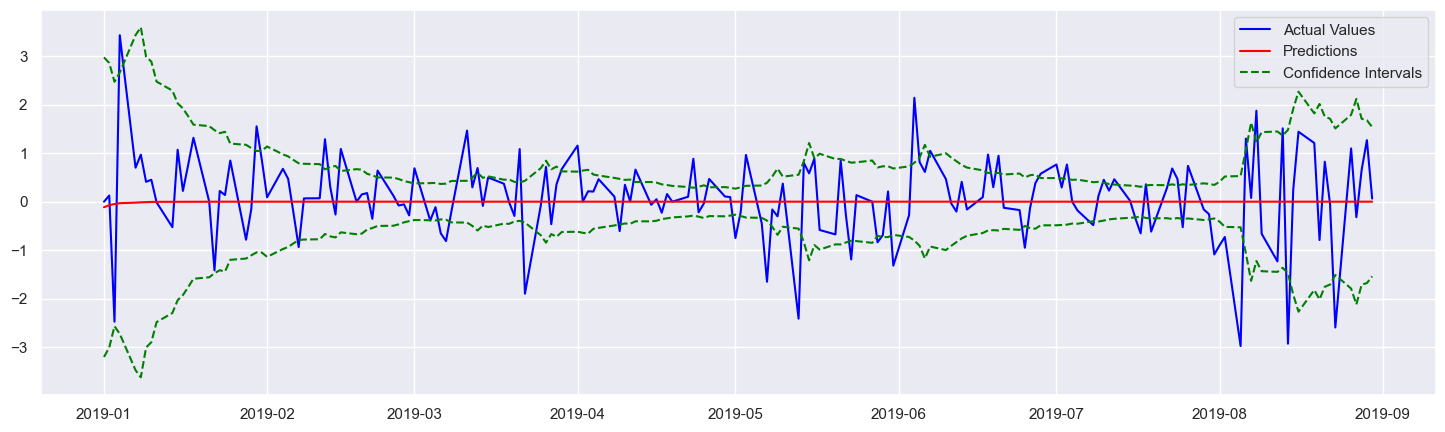

In [17]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(test_df["spx_ret"], color = "blue", label = "Actual Values")

plt.plot(arma_garch_predictions_df["Predictions"][test_df.index], color = "red", label = "Predictions")
plt.plot(arma_garch_predictions_df["lower spx_ret"][test_df.index], color = "green", linestyle = "--", label = "Confidence Intervals")
plt.plot(arma_garch_predictions_df["upper spx_ret"][test_df.index], color = "green", linestyle = "--")

plt.legend()
plt.plot()